https://bindsnet-docs.readthedocs.io/guide/guide_part_i.html

In [43]:
from bindsnet.network import Network
from bindsnet.network.nodes import LIFNodes
from bindsnet.network.nodes import Input
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
import torch
import matplotlib.pyplot as plt


In [44]:
duration = 500 # in number timesteps
dt = 1 #in ms

network = Network(dt=dt, learning=True, batch_size=1, reward_fn=None)

In [45]:
input_layer = Input(n=100, traces=True)
layer1 = LIFNodes(n=1000, traces=True)

network.add_layer(
        layer=input_layer, name="simulated input")

network.add_layer(
    layer=layer1, name="light-receptive neurons")

forward_connection = Connection(
        source= input_layer,
        target= layer1,
        w=0.05+0.1*torch.randn((input_layer.n, layer1.n)))

network.add_connection(
        connection=forward_connection, source= "simulated input"
        ,target= "light-receptive neurons")

network

Network(
  (simulated input): Input()
  (light-receptive neurons): LIFNodes()
  (simulated input_to_light-receptive neurons): Connection(
    (source): Input()
    (target): LIFNodes()
  )
)

"Custom nodes objects can be implemented by sub-classing bindsnet.network.nodes.Nodes, an abstract class with common logic for neuron simulation. The functions forward(self, x: torch.Tensor) (computes effects of input data on neuron population; e.g., voltage changes, spike occurrences, etc.), reset_state_variables(self) (resets neuron state variables to default values), and _compute_decays(self) must be implemented, as they are included as abstract functions of bindsnet.network.nodes.Nodes"

In [34]:
print(network.connections)
print(forward_connection.w)

{('simulated input', 'light-receptive neurons'): Connection(
  (source): Input()
  (target): LIFNodes()
)}
Parameter containing:
tensor([[-0.0621,  0.0511, -0.0487,  ..., -0.0670, -0.0372,  0.0027],
        [-0.0540,  0.0223,  0.0957,  ...,  0.0132, -0.1686,  0.0082],
        [ 0.0172,  0.1276, -0.0415,  ...,  0.0182, -0.0450, -0.0502],
        ...,
        [ 0.0983, -0.0141, -0.0146,  ...,  0.2033, -0.0604,  0.0409],
        [ 0.1148,  0.1080,  0.0459,  ...,  0.0683, -0.0098,  0.0066],
        [ 0.1667,  0.0161,  0.1474,  ..., -0.0458,  0.0510,  0.0121]])


In [35]:
recurrent_connection = Connection(
    source=input_layer,
    target=layer1,
    w=0.025 * (torch.eye(layer1.n) - 1), # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="light-sensitive neurons",
                                    target="light-sensitive neurons"
)

"Custom connection objects can be implemented by sub-classing bindsnet.network.topology.AbstractConnection, an abstract class with common logic for computing synapse outputs and updates. This includes functions compute (for computing input to downstream layer as a function of spikes and connection weights), update (for updating connection weights based on pre-, post-synaptic activity and possibly other signals; e.g., reward prediction error), normalize (for ensuring weights incident to post-synaptic neurons sum to a pre-specified value), and reset_state_variables (for re-initializing stateful variables for the start of a new simulation)"

In [36]:
my_state_vars = ['s', 'v']

source_monitor = Monitor(
    obj=input_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=duration,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=layer1,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=duration,  # Length of simulation (if known ahead of time).
)

network.add_monitor(
    monitor=source_monitor, name="simulated input")
network.add_monitor(
    monitor=target_monitor, name='light-sensitive neurons')

#network.monitors["input monitor"].recording['s']

In [37]:
input_data = torch.bernoulli(0.1* torch.ones(
    duration, input_layer.n)).byte()

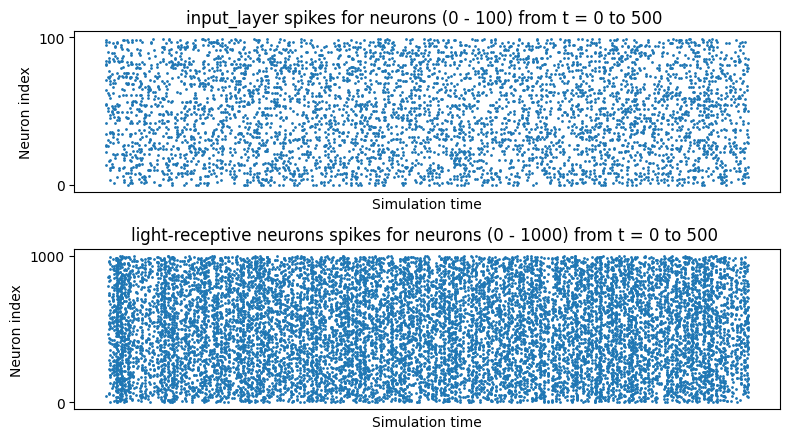

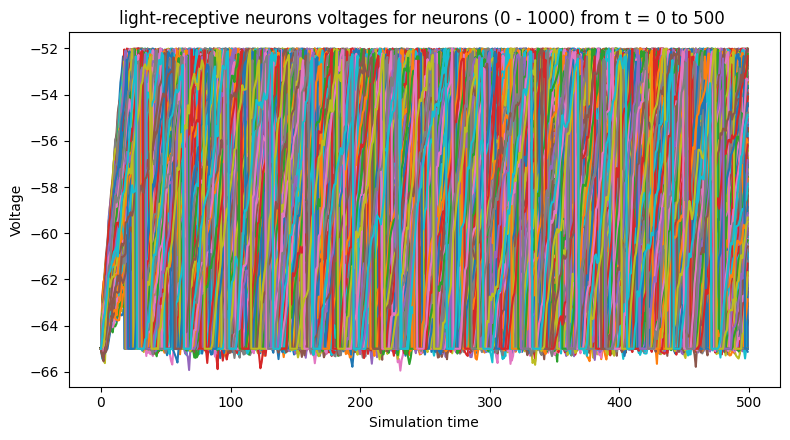

In [38]:
inputs = {"simulated input": input_data}

# Simulate network on input data.
network.run(inputs=inputs, time=duration)

# Retrieve and plot simulation spike, voltage data from monitors.
spikes = {
    "input_layer": source_monitor.get("s"), 
    "light-receptive neurons": target_monitor.get("s")
}
voltages = {"light-receptive neurons": target_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()